In [1]:
from numpy import vstack, sqrt
from pandas import read_csv, DataFrame
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, Sigmoid, Module, MSELoss
from torch.optim import SGD
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix



# **Loading Data**

In [2]:
df = pd.read_csv("predictive_maintenance.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


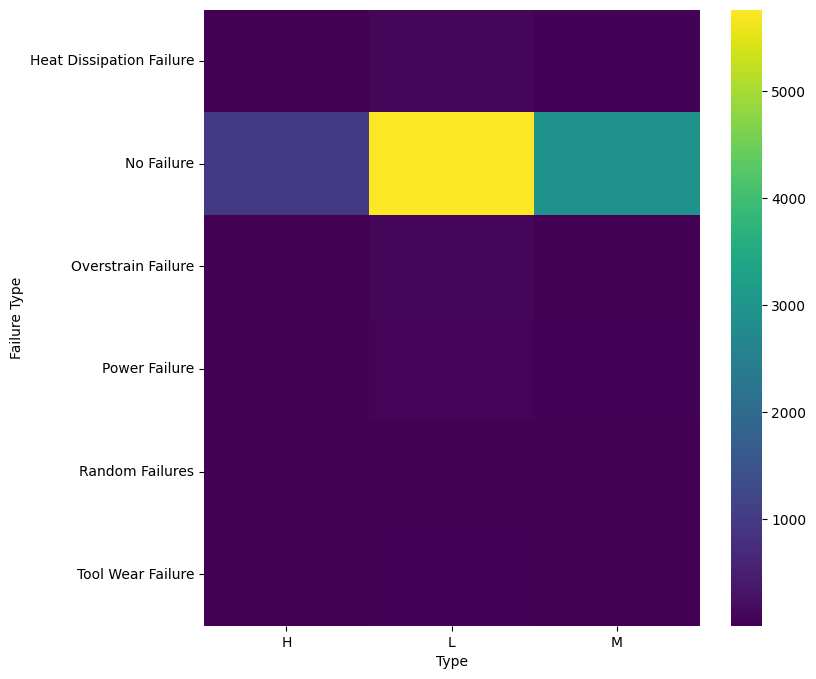

In [3]:
# @title Type vs Failure Type

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Failure Type'].value_counts()
    for x_label, grp in df.groupby('Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Type')
_ = plt.ylabel('Failure Type')

# **Data Preprocessing**

In [4]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [9]:
df.shape

(10000, 10)

In [10]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [12]:
UDI = df.pop('UDI')

In [13]:
df.shape

(10000, 9)

In [14]:
df['Product ID'].unique() # Product ID = QualityVariant + SerialNumber et QualityVariant = Type 

array(['M14860', 'L47181', 'L47182', ..., 'M24857', 'H39412', 'M24859'],
      dtype=object)

In [15]:
Product_ID = df.pop('Product ID')

In [16]:
df.shape

(10000, 8)

In [17]:
df['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

In [18]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# df = pd.get_dummies(df, columns=['Type', 'Product ID'])
# df = pd.get_dummies(df, columns=['Type'])
df['Failure Type'] = label_encoder.fit_transform(df['Failure Type'])
df['Type'] = label_encoder.fit_transform(df['Type'])

In [20]:
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
#scaler = StandardScaler() autre scaler

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [22]:
df_scaled

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1.0,0.304348,0.358025,0.222934,0.535714,0.000000,0.0,0.2
1,0.5,0.315217,0.370370,0.139697,0.583791,0.011858,0.0,0.2
2,0.5,0.304348,0.345679,0.192084,0.626374,0.019763,0.0,0.2
3,0.5,0.315217,0.358025,0.154249,0.490385,0.027668,0.0,0.2
4,0.5,0.315217,0.370370,0.139697,0.497253,0.035573,0.0,0.2
...,...,...,...,...,...,...,...,...
9995,1.0,0.380435,0.333333,0.253783,0.353022,0.055336,0.0,0.2
9996,0.0,0.391304,0.333333,0.270081,0.384615,0.067194,0.0,0.2
9997,1.0,0.402174,0.358025,0.277648,0.406593,0.086957,0.0,0.2
9998,0.0,0.402174,0.370370,0.139697,0.614011,0.098814,0.0,0.2


In [23]:
df_scaled.shape

(10000, 8)

In [24]:
df_scaled['Target'].unique()

array([0., 1.])

In [25]:
df_scaled.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.599700,0.511405,0.531551,0.215818,0.497073,0.426684,0.033900,0.207800
std,0.300115,0.217419,0.183177,0.104356,0.136936,0.251597,0.180981,0.075814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.326087,0.382716,0.148428,0.403846,0.209486,0.000000,0.200000
50%,0.500000,0.521739,0.543210,0.194994,0.498626,0.426877,0.000000,0.200000
75%,1.000000,0.673913,0.666667,0.258440,0.590659,0.640316,0.000000,0.200000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Data visualization**

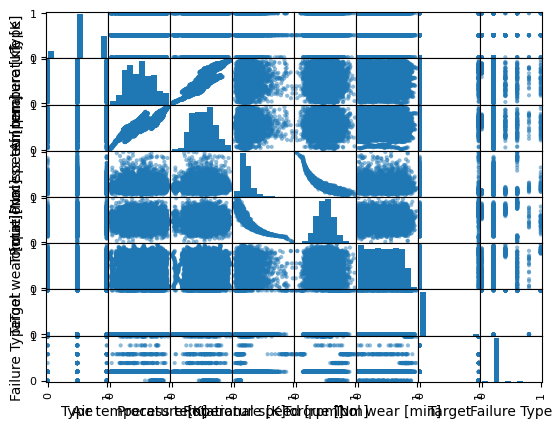

In [26]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_scaled)
plt.show()

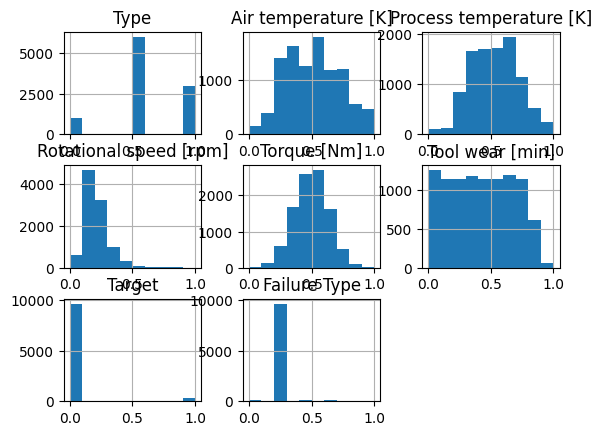

In [27]:
df_scaled.hist()
plt.show()

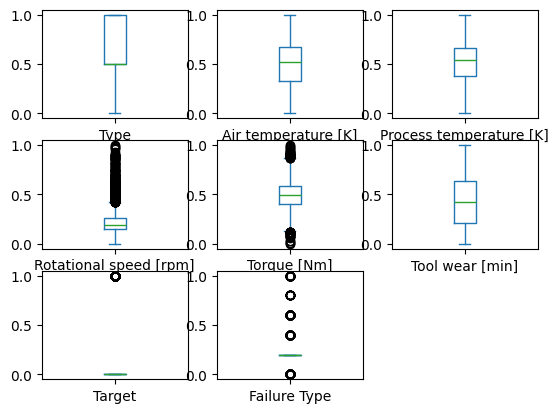

In [28]:
df_scaled.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

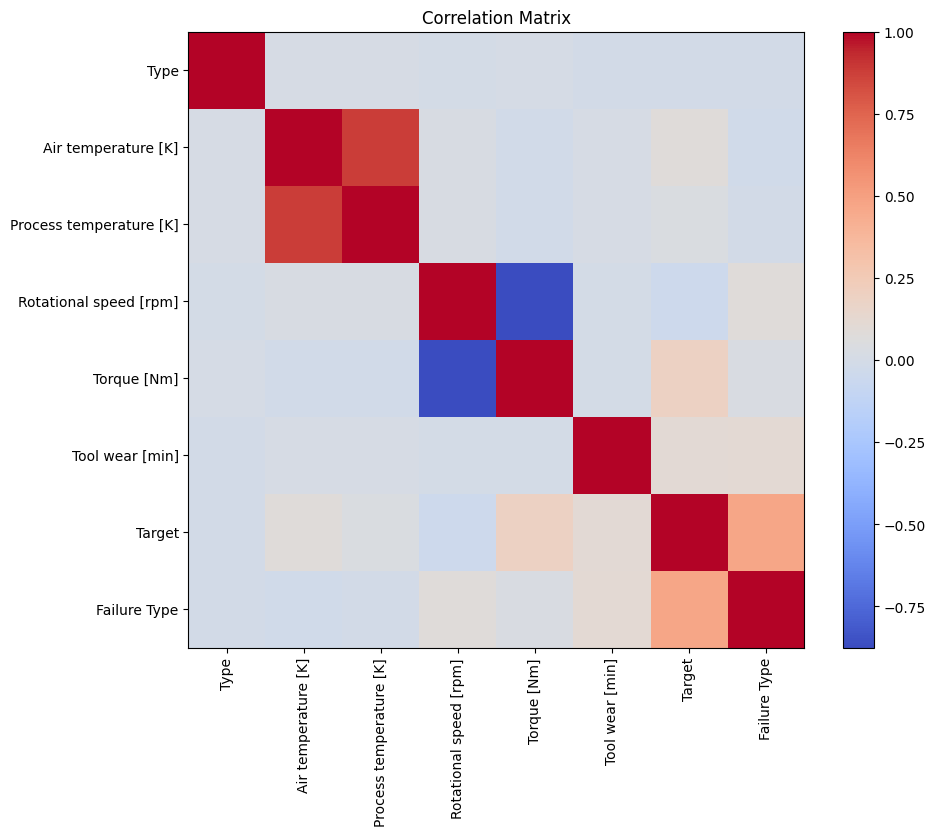

In [29]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

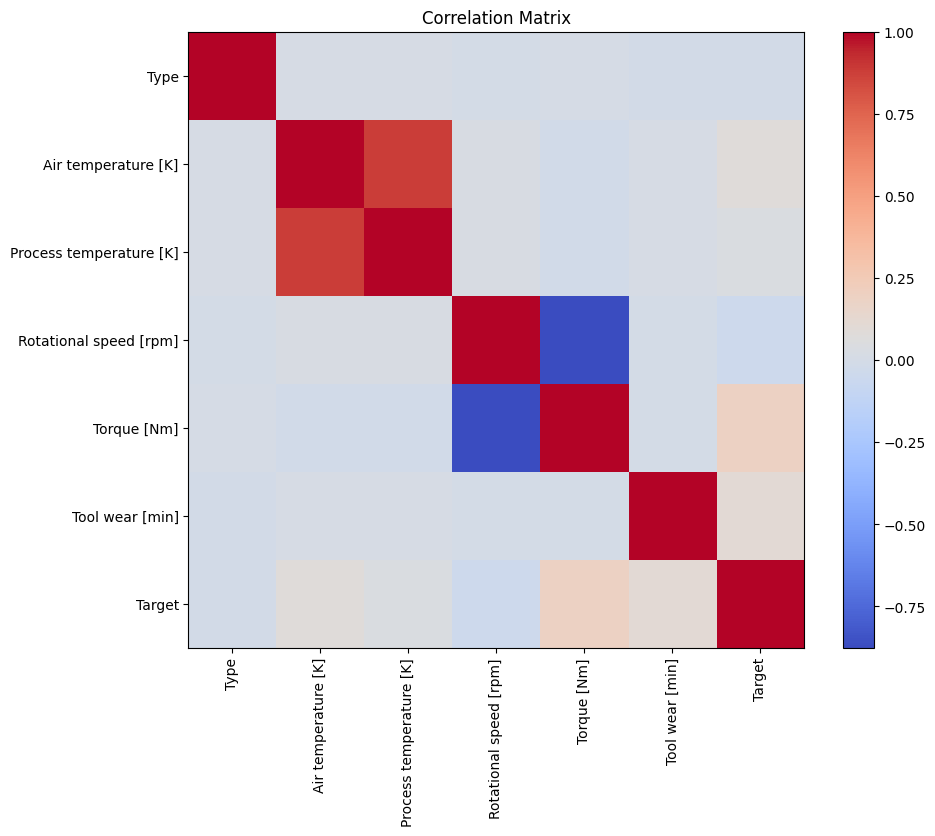

In [30]:
features = ['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       ]
correlation_matrix = df_scaled[features].corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

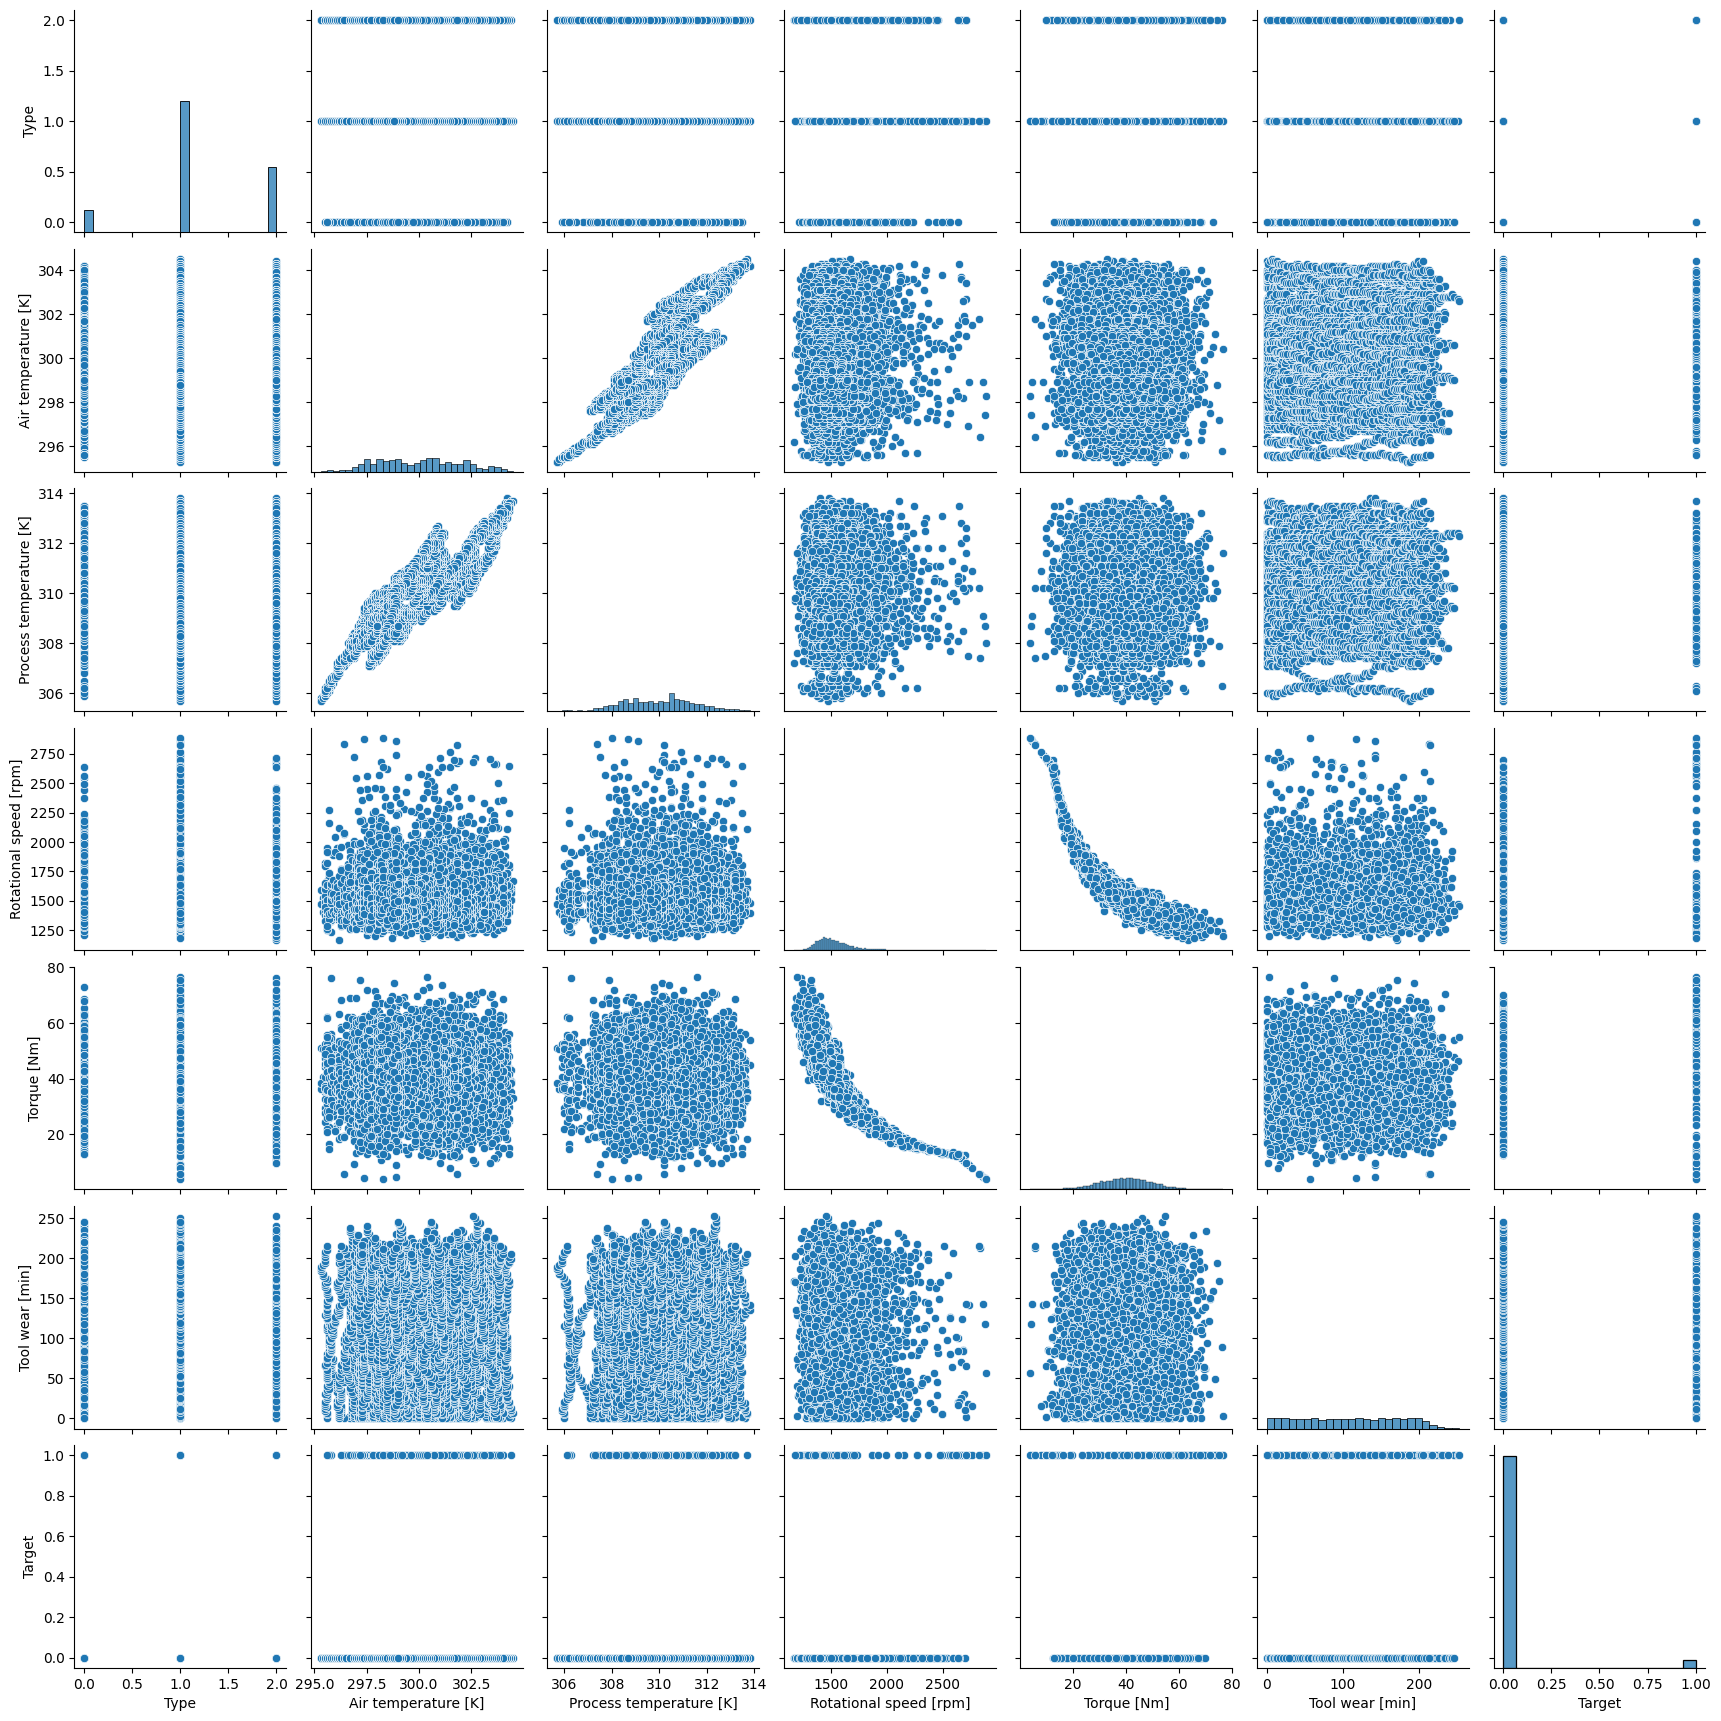

In [31]:
sns.pairplot(df[features])

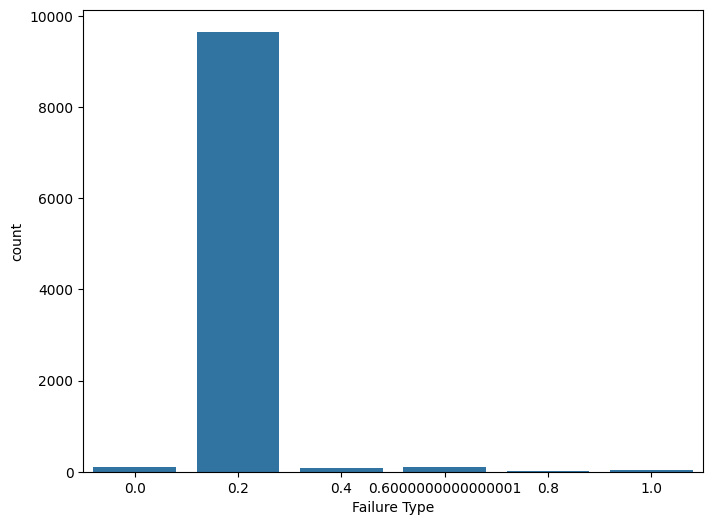

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure Type', data=df_scaled)
plt.show()